<a href="https://colab.research.google.com/github/ytg000629/ai4dl/blob/main/project/roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 설치,import, 데이터 준비



In [ ]:
!pip install keras_preprocessing
!pip install emoji
!pip install autocorrect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import emoji

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from collections import  Counter
plt.style.use('ggplot')

import re
from nltk.tokenize import word_tokenize
import wordcloud
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences #keras_preprocessing

from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, SimpleRNN, Bidirectional
from keras.initializers import Constant
from sklearn.model_selection import train_test_split

import os 
import warnings
warnings.filterwarnings(action  = 'ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from autocorrect import Speller 

In [ ]:
#%config Completer.use_jedi = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv('drive/MyDrive/nlp-getting-started/train.csv')
df_test = pd.read_csv('drive/MyDrive//nlp-getting-started/test.csv')
df_sample = pd.read_csv('drive/MyDrive//nlp-getting-started/sample_submission.csv')

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_train.shape

(7613, 5)

In [ ]:
df_test.shape

(3263, 4)

In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# 데이터 전처리

In [ ]:
#불용어 사전 정의
stop=set(stopwords.words('english'))

#spell check 진행 정도 파악을 위
tqdm.pandas()

def text_preproccessing(df):  
    
    df = df.copy()
    
    # URL 제거
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    # HTML tag 제거
    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    # 구두점 제거
    def remove_punct(text):
        table=str.maketrans('','',string.punctuation)
        return text.translate(table)

    # 이모티콘 제거
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    # 불용어 제거
    def remove_stopwords(x):
        return ' '.join([i for i in x.split() if i not in stop])


    # 스펠링 교정
    def spell_check(x):
        spell = Speller(lang='en')
        return " ".join([spell(i) for i in x.split()])


    df['text']=df['text'].apply(lambda x : remove_URL(x))
    df['text']=df['text'].apply(lambda x : remove_html(x))
    df['text']=df['text'].apply(lambda x : remove_punct(x))
    df['text']=df['text'].apply(lambda x : remove_emoji(x))
    df['text']=df['text'].apply(lambda x : remove_stopwords(x))
    #df['text']=df['text'].progress_apply(lambda x : spell_check(x))


    return df

In [ ]:
df_train = text_preproccessing(df_train)
df_test = text_preproccessing(df_test)

#50분 정도 소요

In [ ]:
df_train.shape

(7613, 5)

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds Reason earthquake May ALLAH Forgive us,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked shelter place notified off...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1


In [ ]:
df_test.shape

(3263, 4)

In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened terrible car crash
1,2,NaN,NaN,Heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 China Taiwan


In [ ]:
df=pd.concat([df_train,df_test])
df.shape

(10876, 5)

# roBerta

In [ ]:
import tensorflow_hub as hub
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
#!pip install tokenization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert: filename=bert-2.2.0-py3-none-any.whl size=3745 sha256=06e1f08379158eac5799c35bda6a6f0467d3ec4416dbe4d87820a7646eaf1962
  Stored in directory: /root/.cache/pip/wheels/d0/97/c8/5775d57c323970511488d9b53ce66cf0ded394fe4b4f6e0afb
  Created wheel for erlastic: filename=erlastic-2.0.0-py3-none-any.whl size=6777 sha256=a70345ab00e11323321528070702033b2da8cc793c4c4042a82fd7fc9c92a098
  Stored in directory: /root/.cache/pip/wheels/f5/ca/b1/ce71c2e0e9e0df3786697d06d53574be03ef86cd4fb0e2cb99
Successfully built bert erlastic


In [ ]:
!pip install bert-tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 5.7 MB/s eta 0:00:00


In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    #could be pooled_output, sequence_output yet sequence output provides for each input token (in context)
    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    #out = Dense(128, activation='relu')(clf_output)
    #out = tf.keras.layers.Dropout(0.5)(out)
    #out = Dense(1,activation = 'sigmoid')(out)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    
    optimizer = Adam(learning_rate=1e-5)
    #loss = BinaryCrossentropy(from_logits = True)

    #metric = BinaryAccuracy('accuracy')
    #specifying optimizer
    model.compile(optimizer = optimizer, loss='BinaryCrossentropy', metrics='accuracy')
    
    return model

In [ ]:
from bert import tokenization

In [ ]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

In [ ]:
#train_data, val_data, train_labels, val_labels = train_test_split(df_train.text.values, df_train.target.values, test_size=0.2, random_state=10)
train_data, val_data, train_labels, val_labels = train_test_split(df['text'][:df_train.shape[0]].values, df_train['target'].values, test_size=0.2, stratify=df_train['target'].values, random_state=10)

In [ ]:
#vocab file from pre-trained BERT for tokenization
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

#returns true/false depending on if we selected cased/uncased bert layer
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

#Create the tokenizer
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

#tokenizing the training and testing data
train_data = bert_encode(train_data, tokenizer, max_len=160)
val_data = bert_encode(val_data, tokenizer, max_len=160)


test_input = bert_encode(df['text'][df_train.shape[0]:].values, tokenizer, max_len=160)


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 160)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 160)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 1024),       335141889   ['input_word_ids[0][0]',         
                                 (None, 160, 1024)]               'input_mask[0][0]',         

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=2                               
    ),
    
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    )
]

In [ ]:
train_history = model.fit(
    train_data, train_labels,
    validation_data = [val_data, val_labels],
    epochs=20,
    callbacks=callbacks_list,
    batch_size=16
    #배치사이즈 늘리니까 오류남..
    #줄이자니 오래걸림
)

Epoch 1/20
381/381 [==============================] - ETA: 0s - loss: 0.4709 - accuracy: 0.7854
Epoch 1: val_accuracy improved from -inf to 0.81418, saving model to checkpoint_path.keras
381/381 [==============================] - 804s 2s/step - loss: 0.4709 - accuracy: 0.7854 - val_loss: 0.4432 - val_accuracy: 0.8142
Epoch 2/20
381/381 [==============================] - ETA: 0s - loss: 0.3512 - accuracy: 0.8509
Epoch 2: val_accuracy improved from 0.81418 to 0.83913, saving model to checkpoint_path.keras
381/381 [==============================] - 679s 2s/step - loss: 0.3512 - accuracy: 0.8509 - val_loss: 0.4000 - val_accuracy: 0.8391
Epoch 3/20
381/381 [==============================] - ETA: 0s - loss: 0.2553 - accuracy: 0.9020
Epoch 3: val_accuracy did not improve from 0.83913
381/381 [==============================] - 651s 2s/step - loss: 0.2553 - accuracy: 0.9020 - val_loss: 0.4856 - val_accuracy: 0.8365
Epoch 4/20
381/381 [==============================] - ETA: 0s - loss: 0.1481 - a

In [ ]:
loaded_model = tf.keras.models.load_model(
       ('checkpoint_path.keras'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [ ]:
history_dict = train_history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

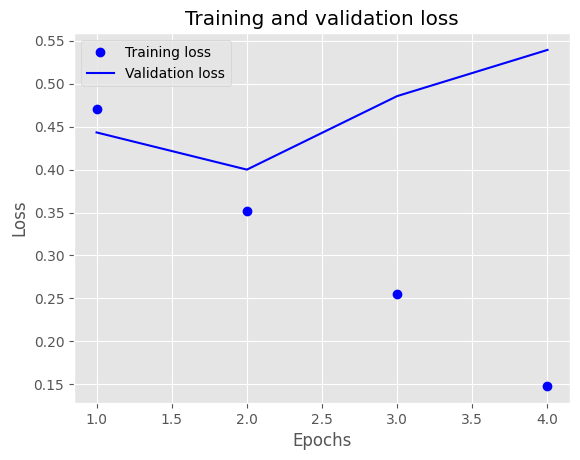

In [ ]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

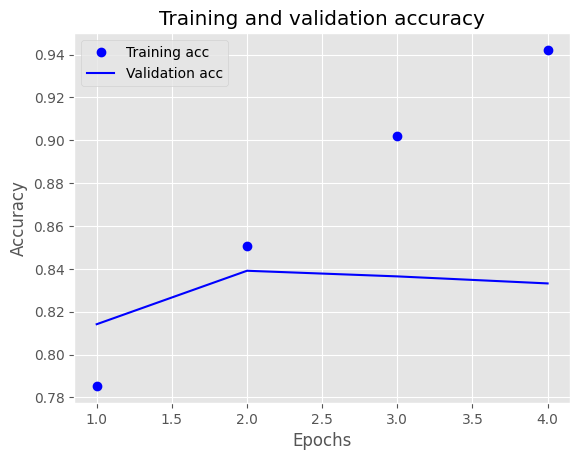

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
test_pred = loaded_model.predict(test_input)
df_sample['target'] = test_pred.round().astype(int)
df_sample.to_csv('roberta.csv', index=False)

102/102 [==============================] - 124s 1s/step


NameError: ignored